# Tracking Global Coronavirus Cases

This notebook has been used to try out different skills using a global coronavirus dataset from https://opendata.ecdc.europa.eu/covid19/casedistribution/json/.

### Import relevant modules

In [100]:
import urllib.request, urllib.parse, urllib.error
import json
import time as tm
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import pycountry
import plotly.express as px

### Retrieve data from url and parse json file

In [46]:
# covid data url
url = 'https://opendata.ecdc.europa.eu/covid19/casedistribution/json'

print('Retrieving data from', url)
uh = urllib.request.urlopen(url)
data = uh.read().decode()
print('Retrieved', len(data), 'characters')


Retrieving data from https://opendata.ecdc.europa.eu/covid19/casedistribution/json
Retrieved 5220418 characters


### Create pandas dataframe

In [103]:
js = json.loads(data)
lst = list(js['records'])
df = pd.DataFrame.from_dict(lst)
df = df.replace('_', ' ', regex=True)

### Fig.1: Comparing UK and Italy

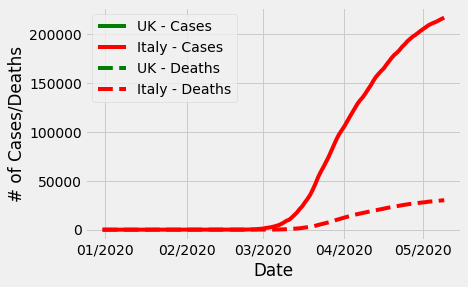

In [104]:
# Create copy of dataframe and ensure correct data types and index
df1 = df.copy()
df1['dateRep']       =   pd.to_datetime(df1['dateRep'], dayfirst = True)
df1['cases']         =   pd.to_numeric(df1['cases'])
df1['deaths']        =   pd.to_numeric(df1['deaths'])
df1.set_index('dateRep')

# Create subsets of dataframe
uk      = df1[df1['countriesAndTerritories'] == 'United_Kingdom'].sort_values(by = 'dateRep')
italy   = df1[df1['countriesAndTerritories'] == 'Italy'].sort_values(by = 'dateRep')

# Plot cumulative deaths and cases
fig, ax = plt.subplots()

plt.plot(uk['dateRep'],uk['cases'].cumsum(), 'g-', label = 'UK - Cases')
plt.plot(italy['dateRep'],italy['cases'].cumsum(), 'r-', label = 'Italy - Cases')
plt.plot(uk['dateRep'],uk['deaths'].cumsum(), 'g--', label = 'UK - Deaths')
plt.plot(italy['dateRep'],italy['deaths'].cumsum(), 'r--', label = 'Italy - Deaths')
plt.xlabel('Date')
plt.ylabel('# of Cases/Deaths')
plt.legend()

# Format tick labels
months = mdates.MonthLocator()  # every month
months_fmt = mdates.DateFormatter('%m/%Y')
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(months_fmt)

plt.show()

### Fig.2: Cases per continent

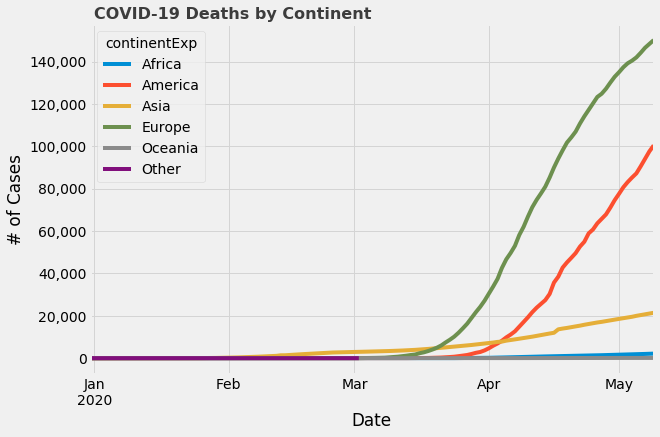

In [106]:
df2 = df.copy()
df2['dateRep']       =   pd.to_datetime(df2['dateRep'], dayfirst = True)
df2['cases']         =   pd.to_numeric(df2['cases'])
df2['deaths']        =   pd.to_numeric(df2['deaths'])

# Restructure data

df2 = df2.pivot_table(index = 'dateRep', columns = 'continentExp', values = 'deaths', aggfunc=np.sum).cumsum()
df2 = df2.reset_index('dateRep')
df2.set_index(['dateRep'], inplace=True)

# Creating the Visualization
plot = df2.plot(figsize=(9,6), linewidth=4, legend=True)
plot.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plot.grid(color='#d4d4d4')
plot.set_xlabel('Date')
plot.set_ylabel('# of Cases')

# Adding Labels
plot.text(x = df2.index[1], y = int(df2.max().max())+10000, s = "COVID-19 Deaths by Continent", fontsize = 16, weight = 'bold', alpha = .75)
plt.show()

### Fig.3: Cases per Country

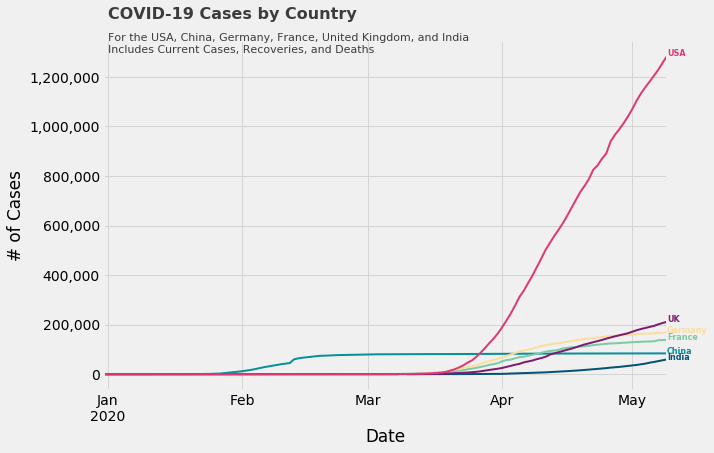

In [109]:
# Restructure data
df3 = df.copy()

# ensure we have the correct data types and set index
df3['dateRep']       =   pd.to_datetime(df3['dateRep'], dayfirst = True)
df3['cases']         =   pd.to_numeric(df3['cases'])
df3['deaths']        =   pd.to_numeric(df3['deaths'])

countries = ['India', 'Germany', 'United Kingdom', 'United States of America', 'France', 'China']
df3 = df3[df3['countriesAndTerritories'].isin(countries)]
df3 = df3.pivot(index = 'dateRep', columns = 'countriesAndTerritories', values = 'cases').cumsum()
countries = list(df3.columns)
covid = df3.reset_index('dateRep')
covid.set_index(['dateRep'], inplace=True)
covid.columns = countries
covid.rename(columns = {'United Kingdom':'UK','United States of America':'USA'}, inplace = True)

# Generating Colours and Style
colors = {'China':'#089099', 'France':'#7CCBA2', 'Germany':'#FCDE9C', 'India':'#045275', 'UK':'#7C1D6F', 'USA':'#DC3977'}
plt.style.use('fivethirtyeight')

# Creating the Visualization
plot = covid.plot(figsize=(9,6), color=list(colors.values()), linewidth=2, legend=False)
plot.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plot.grid(color='#d4d4d4')
plot.set_xlabel('Date')
plot.set_ylabel('# of Cases')

# Assigning Colour
for country in list(colors.keys()):
    plot.text(x = covid.index[-1], y = covid[country].max(), color = colors[country], s = country, fontsize = 8, weight = 'bold')

# Adding Labels
plot.text(x = covid.index[1], y = int(covid.max().max())+150000, s = "COVID-19 Cases by Country", fontsize = 16, weight = 'bold', alpha = .75)
plot.text(x = covid.index[1], y = int(covid.max().max())+15000, s = "For the USA, China, Germany, France, United Kingdom, and India\nIncludes Current Cases, Recoveries, and Deaths", fontsize = 11, alpha = .75)
plt.show()

### Fig.4: Cases per capita & Fig.5: Deaths per capita

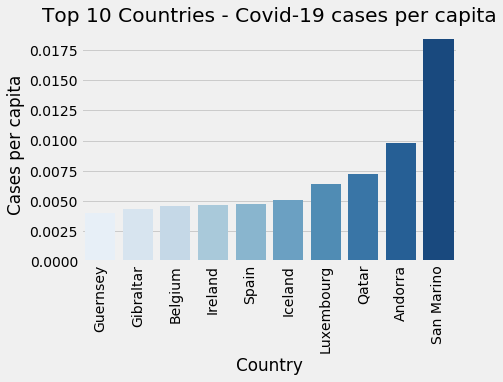

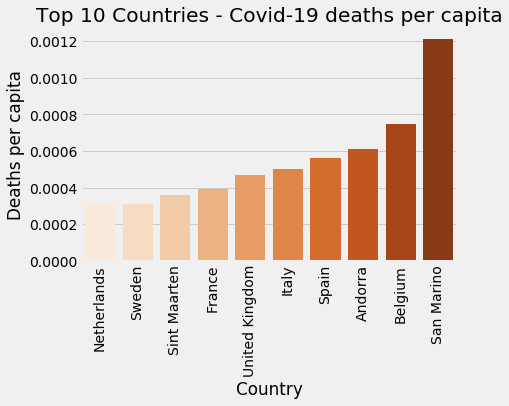

In [110]:
# get data into format we want
df4 = df.copy()
df4 = df4[['countriesAndTerritories', 'cases', 'deaths', 'popData2018']]
df4['cases'] = pd.to_numeric(df4['cases'])
df4['deaths'] = pd.to_numeric(df4['deaths'])
df4['popData2018'] = pd.to_numeric(df4['popData2018'])
df4 = df4.groupby(['countriesAndTerritories', 'popData2018']).sum()
df4.reset_index(inplace=True)

# ensure we are not hampered by nulls or 0s
df4 = df4.loc[(df4['cases'] > 0) & (df4['popData2018'] > 10000)]

# type data
df4['popData2018'] = pd.to_numeric(df4['popData2018'])
df4['cases'] = pd.to_numeric(df4['cases'])
df4['deaths'] = pd.to_numeric(df4['deaths'])

# create ratios
df4['casesPerCapita'] = df4['cases']/df4['popData2018']
df4['deathsPerCapita'] = df4['deaths']/df4['popData2018']

# plot data
cases = df4.sort_values(by=['casesPerCapita'], ascending=True)[-10:]
sns.barplot(x='countriesAndTerritories', y='casesPerCapita', data = cases, 
            palette = 'Blues')
plt.xticks(rotation=90)
plt.xlabel("Country")
plt.ylabel("Cases per capita")
plt.title("Top 10 Countries - Covid-19 cases per capita")
plt.show()

# plot data
deaths = df4.sort_values(by=['deathsPerCapita'], ascending=True)[-10:]
sns.barplot(x='countriesAndTerritories', y='deathsPerCapita', data = deaths, 
            palette = 'Oranges')
plt.xticks(rotation=90)
plt.xlabel("Country")
plt.ylabel("Deaths per capita")
plt.title("Top 10 Countries - Covid-19 deaths per capita")
plt.show()

### Fig.6: Plot global cases on a map

In [152]:
df6 = df.copy()
df7['cases'] = pd.to_numeric(df7['cases'])
df7['dateRep'] = pd.to_datetime(df7['dateRep'], dayfirst = True)
df7['dateRep'] = df7['dateRep'].dt.strftime('%Y-%m-%d')
df7 = df7.sort_values(by=['dateRep'])

fig = px.choropleth(data_frame = df7,
                    locations= "countryterritoryCode",
                    color= "cases",  # value in column 'cases' determines color
                    hover_name= "countriesAndTerritories",
                    color_continuous_scale= 'Peach',  #  color scale red, yellow green
                    animation_frame= "dateRep")

fig.show()

### Fig.7: Plot global deaths on a map

In [149]:
df7 = df.copy()
df7['deaths'] = pd.to_numeric(df7['deaths'])
df7['dateRep'] = pd.to_datetime(df7['dateRep'], dayfirst = True)
df7['dateRep'] = df7['dateRep'].dt.strftime('%Y-%m-%d')
df7 = df7.sort_values(by=['dateRep'])


fig = px.choropleth(data_frame = df7,
                    locations= "countryterritoryCode",
                    color= "deaths",  # value in column 'cases' determines color
                    hover_name= "countriesAndTerritories",
                    color_continuous_scale= 'Peach',  #  color scale red, yellow green
                    animation_frame= "dateRep")

fig.show()